# Imports

In [ ]:
import numpy as np
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import IchimokuLibrary
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import random
import os
from dateutil.relativedelta import relativedelta

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import arch.bootstrap as ab

In [2]:
START = "2015-01-01"
END = "2025-01-01"
TICKER = "btcusd"
TITLE = TICKER + " - " + (datetime.now()).strftime("%Y-%m-%d - %H:%M:%S")

In [3]:
# data = yf.download("^GSPC",start=START, end=END,multi_level_index=False)
# data.to_csv("data2.csv")

In [4]:
data = pd.read_csv("data2.csv", index_col=0, parse_dates=True)

# data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))
#
# data.dropna(inplace=True)

In [5]:
data = data.drop(columns=["High", "Low", "Open", "Volume"])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [7]:
returns = (np.log(data["Close"] / data["Close"].shift(1)).dropna())

# apply_ichi(returns.cumsum()).plot()

# ichi = apply_ichi(returns.cumsum())
# ichi

# Signals

<Axes: >

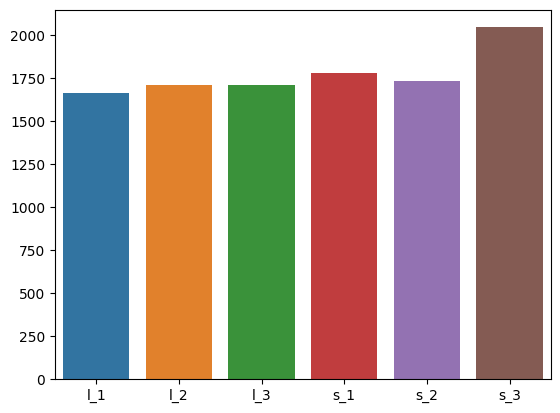

In [8]:
sns.barplot(pd.DataFrame([{signal.__name__: signal(IchimokuLibrary.apply_ichi(data["Close"])).value_counts().iloc[0]} for signal in IchimokuLibrary.BULLISH_SIGNALS + IchimokuLibrary.BEARISH_SIGNALS]))

# Entry

<Axes: >

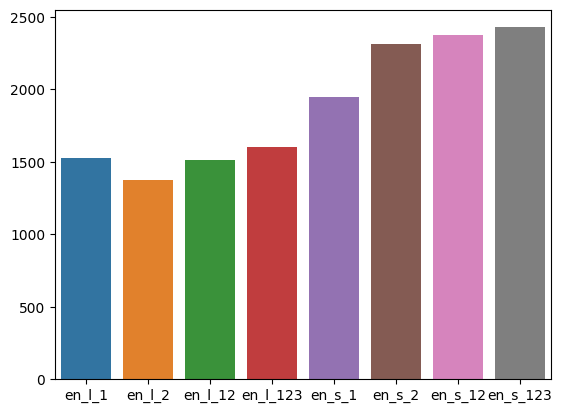

In [9]:
sns.barplot(pd.DataFrame(
    [{x.__name__: x(IchimokuLibrary.apply_ichi(data["Close"])).value_counts().iloc[0]} for x in IchimokuLibrary.ENTRY_SIGNALS_BULL + IchimokuLibrary.ENTRY_SIGNALS_BEAR]))

# Exit

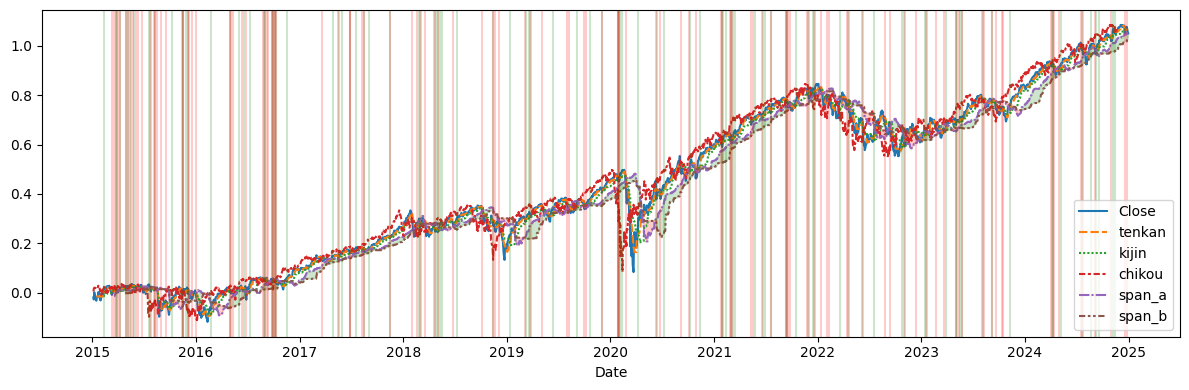

In [10]:
plt.figure(figsize=(12, 4))

ichi_data = IchimokuLibrary.apply_ichi(returns.cumsum())

data_here = ichi_data[:]

ax = sns.lineplot(data=data_here)

signal = IchimokuLibrary.en_l_1

mask = (signal(data_here).dropna() == 1) & (signal(data_here).dropna().shift(1) == 0)

for index, value in mask.items():
    if value:
        ax.axvline(index, alpha=0.2, color="green")

signal = IchimokuLibrary.ex_l_1

mask = (signal(data_here).dropna() == 1) & (signal(data_here).dropna().shift(1) == 0)


for index, value in mask.items():
    if value:
        ax.axvline(index, alpha=0.2, color="red")

ax.fill_between(data_here.index, data_here["span_a"], data_here["span_b"], where=data_here["span_a"] > data_here["span_b"], color="green", alpha=0.2)
ax.fill_between(data_here.index, data_here["span_a"], data_here["span_b"], where=data_here["span_a"] < data_here["span_b"], color="red", alpha=0.2)

plt.tight_layout()

plt.show()

np.float64(0.14783315946836104)

In [11]:
(returns.mean() / returns.std()) * np.sqrt(12)

np.float64(0.12833039679324232)

# Trading Ichimoku

In [12]:
ichi_data = IchimokuLibrary.apply_ichi(returns.cumsum())

trading_data = pd.DataFrame(index=pd.DatetimeIndex(ichi_data.index))

# strategies_l = [[ex_l_1,[en_l_1, en_l_2, en_l_12, en_l_123]], [ex_l_2, [en_l_1, en_l_12, en_l_123]], [ex_l_3, [en_l_2, en_l_12, en_l_123]], [ex_l_4, [en_l_12, en_l_123]], [ex_l_5, [en_l_123]]]
# strategies_s = [[ex_s_1,[en_s_1, en_s_2, en_s_12, en_s_123]], [ex_s_2, [en_s_1, en_s_12, en_s_123]], [ex_s_3, [en_s_2, en_s_12, en_s_123]], [ex_s_4, [en_s_12, en_s_123]], [ex_s_5, [en_s_123]]]

count = 0
for exit, entry_list in IchimokuLibrary.STRATEGIES_L:
    print(exit)
    for entry in entry_list:
        print(f"    {entry}")
        count += 1

print(f"{count=}")

ex_l_1
    en_l_1
    en_l_2
    en_l_12
    en_l_123
ex_l_2
    en_l_1
    en_l_12
    en_l_123
ex_l_3
    en_l_2
    en_l_12
    en_l_123
ex_l_4
    en_l_12
    en_l_123
ex_l_5
    en_l_123
count=13


In [13]:
df = IchimokuLibrary.trade(returns, IchimokuLibrary.en_l_1, IchimokuLibrary.ex_l_3)
print(df)
# ichi_data["Close"]

TypeError: trade() missing 3 required positional arguments: 'short', 'medium', and 'long'

In [ ]:
IchimokuLibrary.sharpe_ratio(returns, IchimokuLibrary.en_l_1, IchimokuLibrary.ex_l_1)

TypeError: sharpe_ratio() missing 3 required positional arguments: 'short', 'medium', and 'long'

In [ ]:
columns = []
for strategy in IchimokuLibrary.STRATEGIES_L:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        columns.append((ex, en))

multi_index_columns = pd.MultiIndex.from_tuples(columns)
trading_data = pd.DataFrame(columns=multi_index_columns)

for exit, entry_list in IchimokuLibrary.STRATEGIES_L:
    for entry in entry_list:
        # print(f"{exit.__name__} - {e.__name__}")
        out = (IchimokuLibrary.trade(returns.cumsum(),entry,exit))
        # print(exit)
        trading_data[(exit, entry)] = out

trading_data

TypeError: trade() missing 3 required positional arguments: 'short', 'medium', and 'long'

# Bootstrapping

In [14]:
returns = np.log(data["Close"] / data["Close"].shift(1)).dropna()

In [15]:
block_length = ab.optimal_block_length(returns ** 2)["stationary"].iloc[0]

In [16]:
bs = ab.StationaryBootstrap(block_length, returns, seed=44)

In [17]:
results = bs.apply(IchimokuLibrary.sharpe_ratio, 100, {"entry":IchimokuLibrary.en_l_1, "exit":IchimokuLibrary.ex_l_1})
# run time - 2500 - 2m 58s
# run time - 100 -      7s

TypeError: sharpe_ratio() missing 3 required positional arguments: 'short', 'medium', and 'long'

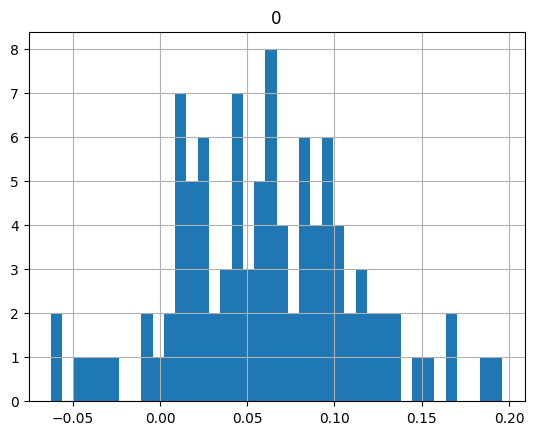

In [ ]:
sr = pd.DataFrame(results[:, -1:])

fig = sr.hist(bins=40)

In [ ]:
# cov = bs.cov(IchimokuLibrary.sharpe_ratio, 100, extra_kwargs={"entry":en_l_1, "exit":ex_l_1})
# run time 2025/05/18 15:07 - 1000 - 1m 16s
# run time 2025/05/18 15:09 - 1000 - 1m 16s

NameError: name 'en_l_1' is not defined

In [ ]:
# ci = bs.conf_int(IchimokuLibrary.sharpe_ratio, 100, method="basic", extra_kwargs={"entry":en_l_1, "exit":ex_l_1})
# run time 100      -      7.4s
# run time 1_000    -  1m 16.6s
# run time 10_000   - 11m 46.7s
    

In [ ]:
# ci = pd.DataFrame(ci, index=["Lower", "Upper"], columns=["mu", "sigma", "Sharpe"])
# print(ci)

             mu     sigma    Sharpe
Lower -0.000093  0.014726  0.000078
Upper  0.002593  0.020367  0.151350


# CI for sharpe

In [ ]:

# Initialisation
columns = []
for strategy in IchimokuLibrary.STRATEGIES_L:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        for measure in ["mu", "sigma", "Sharpe"]:
            columns.append((ex, en, measure))

multi_index_columns = pd.MultiIndex.from_tuples(columns)
trading_ci = pd.DataFrame(columns=multi_index_columns, index=["Lower", "Upper"])
count = 0

# Tests
for exit, entry_list in IchimokuLibrary.STRATEGIES_L:
    for entry in entry_list:
        print(f"{datetime.now().strftime("%H:%M:%S")} : {exit.__name__} - {entry.__name__} - {count=}")
        out = (bs.conf_int(IchimokuLibrary.sharpe_ratio, 100, extra_kwargs={"entry":entry, "exit":exit}))
        # print(exit)
        trading_ci[(exit, entry)] = out
        count += 1

trading_ci

# 1000 = 15m 36.5s

AttributeError: 'str' object has no attribute '__name__'

In [ ]:
trading_ci.to_csv(f"trading_confidence_intervals_{datetime.datetime.now().strftime("%d-%m-%Y, %H-%M-%S")}.csv")

In [ ]:
np.any(trading_ci.loc["Lower"] > 0)

np.True_

# SPA

In [ ]:
def spa_test(data, trade_parameters, alpha=0.05, verbose=False):
    """
    Benchmark is buy and hold
    
    """
    
    strategy_loss = -IchimokuLibrary.trade(data, trade_parameters["entry"], trade_parameters["exit"], trade_parameters["short"], trade_parameters["medium"], trade_parameters["long"])

    # strategy_loss.plot()

    benchmark_loss = -data


    a = ab.SPA(benchmark_loss, strategy_loss,reps=100)

    a.compute()

    if verbose:
        if a.pvalues["consistent"] < alpha:
            print(f"reject null, The strategy is NOT superior to all benchmarks., p value is {a.pvalues["consistent"]}")
        else:
            print(f"fail to reject null, The strategy is not inferior to any benchmark (supports superiority), p value is {a.pvalues["consistent"]}")
            
    return a.pvalues["consistent"]

In [ ]:
trade_parameters = {"entry":"en_l_1", "exit":"ex_l_5", "short":9, "medium": 26, "long":52}

spa_test(returns, trade_parameters)

np.float64(0.12)

<Axes: xlabel='Date'>

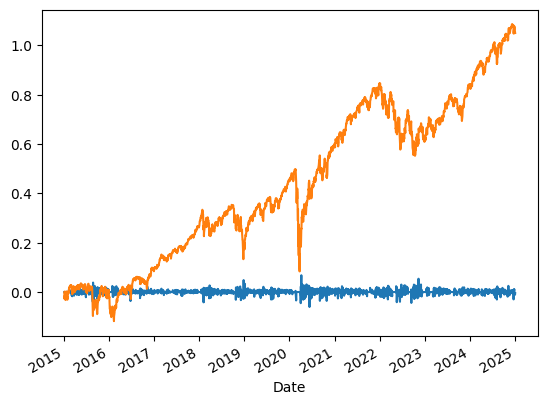

In [ ]:
IchimokuLibrary.trade(returns, "en_l_1", "ex_l_5", 9, 26, 52).plot()
returns.cumsum().plot()

In [ ]:
trading_lengths = {
    'short': range(5,15,2), # check
    'medium': range(17,33,2), # check
    'long': range(35,65,2) # check
}

jobs = product(
    trading_lengths['short'], 
    trading_lengths['medium'],
    trading_lengths["long"],
    ((exit, x) for exit, _entry in IchimokuLibrary.STRATEGIES_L for x in _entry)) # 7800

In [ ]:
# list(jobs)[0][0]
random.seed(44)

# jobs = random.choices(list(universe), k=500)

# jobs = list(jobs)[:10]

# dataframe for results storage
columns = []
for strategy in IchimokuLibrary.STRATEGIES_L:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        columns.append((ex, en))

multi_index_columns = pd.MultiIndex.from_tuples(columns)
multi_index_index = pd.MultiIndex.from_tuples(product(trading_lengths['short'], trading_lengths['medium'],trading_lengths["long"], ["Lower", "Upper"]))

trading_spa = pd.DataFrame(columns=multi_index_columns, index=multi_index_index)
trading_ci.to_excel(file_name)

total = 7800
trades = []
for count, job in enumerate(jobs):
    if count % 250 == 0:
        print(f"{datetime.now().strftime('%H:%M:%S')} - {count}/{total} : {round((count/total)*100,3)}%")

    trades.append(IchimokuLibrary.trade(returns, job[3][1], job[3][0],job[0],job[1],job[2]))

print(np.array(trades))

NameError: name 'trading_ci' is not defined

In [ ]:
np.array(trades).shape

NameError: name 'trades' is not defined

In [ ]:
# All models
spa_buy_and_hold = ab.SPA(-returns.cumsum().values.squeeze(),(returns.cumsum().values - np.array(trades)).T ** 2, reps=1000)
spa_buy_and_hold.compute()
# 6m 44s - btc
# 6m 51s - btc
# reps = 100, 4m 15s - btc
# 3m 56s - SP500
spa_buy_and_hold.pvalues

lower         0.485
consistent    0.485
upper         1.000
dtype: float64

In [ ]:
spa_buy_and_hold.pvalues

lower         0.485
consistent    0.485
upper         1.000
dtype: float64

In [ ]:
spa_oom = ab.SPA(np.zeros(shape=returns.shape),(returns.cumsum().values - np.array(trades)).T ** 2, reps=1000)
spa_oom.compute()
spa_oom.pvalues

lower         0.624
consistent    0.624
upper         1.000
dtype: float64

# Parameter sweep

In [18]:
trading_lengths = {
    'short': range(5,15,2),
    'medium': range(17,33,2),
    'long': range(35,65,2)
}

combinations = product(trading_lengths['short'], trading_lengths['medium'],trading_lengths["long"], IchimokuLibrary.STRATEGIES_L)

(type(combinations))

itertools.product

In [19]:
# try_1 = IchimokuLibrary.confidence_interval(bs,IchimokuLibrary.sharpe_ratio, 5,17,35,("ex_l_1","en_l_1"))
# try_2 = IchimokuLibrary.confidence_interval(bs,IchimokuLibrary.sharpe_ratio, 5,17,37,("ex_l_1","en_l_1"))
# try_3 = bs.conf_int(IchimokuLibrary.sharpe_ratio, 1000, extra_kwargs={"short":5, "medium":17, "long":37, "exit":"ex_l_1", "entry":"en_l_1"})
# try_1
# try_3
# try_1[1]  == try_3

In [20]:
raise

RuntimeError: No active exception to reraise

In [21]:
# list(jobs)[0][0]
random.seed(44)

# jobs = random.choices(list(universe), k=500)

# jobs = list(jobs)[:10]

# dataframe for results storage
columns = []
for strategy in IchimokuLibrary.STRATEGIES_L:
    ex = strategy[0]
    en_list = strategy[1]
    for en in en_list:
        for measure in ["mu", "sigma","Sharpe"]:
            columns.append((ex, en, measure))

multi_index_columns = pd.MultiIndex.from_tuples(columns)
multi_index_index = pd.MultiIndex.from_tuples(product(trading_lengths['short'], trading_lengths['medium'],trading_lengths["long"], ["Lower", "Upper"]))

trading_ci = pd.DataFrame(columns=multi_index_columns, index=multi_index_index)
file_name = "results/sp500.xlsx"
# trading_ci.to_excel(file_name)

In [22]:
trading_ci = pd.read_excel(file_name,header=[0,1,2], index_col=[0,1,2,3])

In [23]:
list((exit) for exit in IchimokuLibrary.STRATEGIES_L)

[['ex_l_1', ['en_l_1', 'en_l_2', 'en_l_12', 'en_l_123']],
 ['ex_l_2', ['en_l_1', 'en_l_12', 'en_l_123']],
 ['ex_l_3', ['en_l_2', 'en_l_12', 'en_l_123']],
 ['ex_l_4', ['en_l_12', 'en_l_123']],
 ['ex_l_5', ['en_l_123']]]

<Axes: xlabel='Date'>

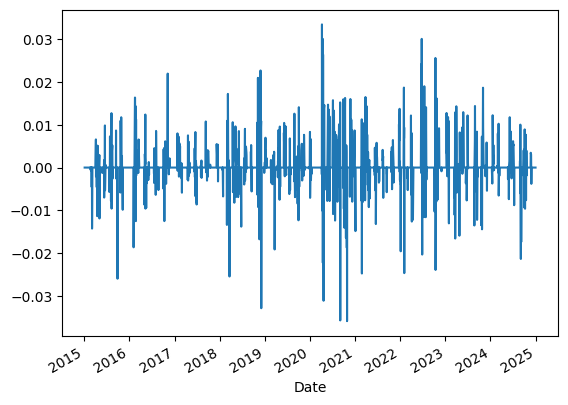

In [24]:
IchimokuLibrary.trade(returns, "en_l_1", "ex_l_1", 15, 30, 50).plot()

In [25]:
IchimokuLibrary.sharpe_ratio(returns, "en_l_1", "ex_l_1", 15, 30, 50)

mu        0.037685
sigma     0.067941
Sharpe    0.554679
dtype: float64

In [26]:
# IchimokuLibrary.confidence_interval(bs, IchimokuLibrary.sharpe_ratio, 15, 30, 50, ("ex_l_1", "en_l_1"))

In [27]:
jobs = product(
    [bs],
    [IchimokuLibrary.sharpe_ratio],
    trading_lengths['short'], 
    trading_lengths['medium'],
    trading_lengths["long"],
    ((exit, x) for exit, _entry in IchimokuLibrary.STRATEGIES_L for x in _entry)) #12_000

# list(jobs)
queue = []
for job in jobs:
    # print(job[1])
    short, medium, long, strategy = job[2:6]
    position = {"short":short, "medium": medium, "long":long, "exit":strategy[0], "entry":strategy[1]}
    if pd.isna(trading_ci.loc[(position["short"], position["medium"], position["long"], "Lower"), (position["exit"], position["entry"], "mu")]):
        queue.append(job)

In [28]:
with ProcessPoolExecutor(max_workers=os.process_cpu_count()-1) as executor:

    futures = []
    for job in queue:
        short, medium, long, strategy = job[2:6]
        position = {"short":short, "medium": medium, "long":long, "exit":strategy[0], "entry":strategy[1]}

        if pd.isna(trading_ci.loc[(position["short"], position["medium"], position["long"], "Lower"), (position["exit"], position["entry"], "mu")]):
            futures.append(executor.submit(IchimokuLibrary.confidence_interval, *job))
            # print(f"{datetime.now().strftime('%H:%M:%S')} - Added : {job}")
        else:
            print(f"{datetime.now().strftime('%H:%M:%S')} - Skipped : {job}")
    
    total = len(futures)
    count = 0
    write_count = 0
    # start_time = datetime.now()
    print(f"{datetime.now().strftime('%H:%M:%S')} - {count}/{total} : {round((count/total)*100,3)}%")
    
    for future in as_completed(futures):
        try:
            result = future.result()
            position = result[0]
            data = result[1]

            trading_ci.loc[(position["short"], position["medium"], position["long"], "Lower"), (position["exit"], position["entry"], "mu")] = data[0][0]
            trading_ci.loc[(position["short"], position["medium"], position["long"], "Upper"), (position["exit"], position["entry"], "mu")] = data[0][1]

            trading_ci.loc[(position["short"], position["medium"], position["long"], "Lower"), (position["exit"], position["entry"], "sigma")] = data[1][0]
            trading_ci.loc[(position["short"], position["medium"], position["long"], "Upper"), (position["exit"], position["entry"], "sigma")] = data[1][1]

            trading_ci.loc[(position["short"], position["medium"], position["long"], "Lower"), (position["exit"], position["entry"], "Sharpe")] = data[2][0]
            trading_ci.loc[(position["short"], position["medium"], position["long"], "Upper"), (position["exit"], position["entry"], "Sharpe")] = data[2][1]

            if write_count >= 100:
                trading_ci.to_excel(file_name)
                print(f"{datetime.now().strftime('%H:%M:%S')} - Written {write_count} to file")
                write_count = 0

            count += 1
            write_count += 1
            
            # remaining_time = ((start_time - datetime.now()).seconds / total) * (total - count)
            # remaining_time = str(datetime.timedelata(seconds=remaining_time))
            print(f"{datetime.now().strftime('%H:%M:%S')} - {count}/{total} : {round((count/total)*100,3)}%")

        except Exception as e:
            print(e.with_traceback())
    
    trading_ci.to_excel(file_name)

15:16:08 - 0/7800 : 0.0%


: 

: 

In [ ]:
((trading_ci.xs("mu",axis=1, level=2).xs("Lower",axis=0,level=3) > 0).sum() / 7800) * 100

ex_l_1  en_l_1      7.307692
        en_l_2      1.666667
        en_l_12     4.615385
        en_l_123    5.576923
ex_l_2  en_l_1      2.692308
        en_l_12     2.884615
        en_l_123    4.384615
ex_l_3  en_l_2      4.807692
        en_l_12     3.076923
        en_l_123    1.935897
ex_l_4  en_l_12     3.653846
        en_l_123    3.910256
ex_l_5  en_l_123    7.512821
dtype: float64